In [5]:
# Let's create synthetic data for regression
from utils import DataModule
import torch

class SyntheticRegressionData(DataModule):

    def __init__(self,w,b,num_train=1000,num_val=1000,noise=0.01,batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        inp_dim = len(w)
        n = num_train + num_val
        self.X = torch.randn((n,inp_dim))
        epsilon = torch.randn((n,1))*noise
        self.y = torch.mm(self.X,w.reshape(-1,1)) + b + epsilon

In [6]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)


In [7]:
print('features:', data.X[0],'\nlabel:', data.y[0])


features: tensor([ 0.0281, -0.0080]) 
label: tensor([4.2625])


In [8]:
from utils import add_to_class
import random 

@add_to_class(SyntheticRegressionData)
def get_dataloader(self,train):
    # Get indices of the data
    if train:
        indices = [i for i in range(self.num_train)]
        # Shuffle indices
        random.shuffle(indices) 
    else:
        indices = [i for i in range(self.num_train,self.num_train + self.num_val)]
    
    number_of_batches = len(indices) // self.batch_size
    for i in range(0,number_of_batches*self.batch_size,self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices,:],self.y[batch_indices,:]



In [9]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [10]:
# More concise implementation uses torch utils
@add_to_class(SyntheticRegressionData)
def get_tensorloader(self,tensors,train,indices = slice(0,None)):
    #Get slices from whole data tensors=(X,y)
    tensors = tuple([a[indices] for a in tensors])
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset,batch_size=self.batch_size,shuffle=train)


@add_to_class(SyntheticRegressionData)
def get_dataloader(self,train):
    idxs = slice(0,self.num_train) if train else slice(self.num_train,None)
    return self.get_tensorloader((self.X,self.y),train,idxs)




In [11]:
for X,y in data.train_dataloader():
    print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1

The last batch has size of 8 data points, if you want to drop last batch write drop_last = True in data loader

In [12]:
from utils import Module
class LinearRegressionScratch(Module):
    def __init__(self,num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # Init parameters
        self.W = torch.normal(0,sigma,(num_inputs,1),requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)


@add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.mm(X,self.W) + self.b

@add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
        l = (y_hat-y)**2 / 2
        return l.mean()


In [13]:
from utils import HyperParameters
class SGD(HyperParameters):
    def __init__(self,params,lr=0.001):
        self.save_hyperparameters()
    

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


@add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.W, self.b], self.lr)





In [14]:
from utils import Trainer

@add_to_class(Trainer) #@save
def prepare_batch(self, batch):
    return batch

In [27]:
@add_to_class(Trainer)
def fit_epoch(self):
    # 1 epoch = all batches iteration
    for batch in self.train_dataloader:
        # Define loss 
        loss = self.model.training_step(self.prepare_batch(batch))
        # Zeroing gradient
        self.optim.zero_grad()
        # Updating parameter grads
        loss.backward()
        with torch.no_grad():
            if self.gradient_clip_val > 0: # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx +=1
    if self.val_dataloader is None:
        return
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

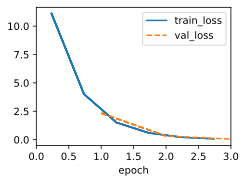

In [28]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2,-3.4]),b=4.2,num_train=1000,num_val=1000)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [29]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.W.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0836, -0.1519])
error in estimating b: tensor([0.2433])


## Concise Implementation of Linear Regression

In [30]:
from utils import Module
class LinearRegression(Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.LazyLinear(1)
        self.net.weight.data.normal_(0,0.01)
        self.net.bias.data.fill_(0)

In [31]:
@add_to_class(LinearRegression)
def loss(self,y_hat,y):
    fn = torch.nn.MSELoss()
    return fn(y_hat,y)


@add_to_class(LinearRegression)
def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(),self.lr)
    return optimizer



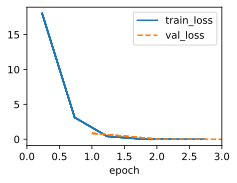

In [32]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2,-3.4]),b=4.2,num_train=1000,num_val=1000)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [33]:
@add_to_class(LinearRegression)
def loss(self,y_hat,y):
    fn = torch.nn.HuberLoss()
    return fn(y_hat,y)



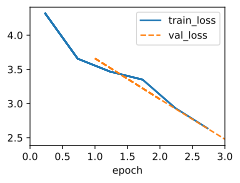

In [34]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2,-3.4]),b=4.2,num_train=1000,num_val=1000)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)